# <font color='#1b4f72'> <b> <center> ResNet </center> </b> </font>

TABLE OF CONTENTS

<a name="#1"> </a>
## <font color='blue'> <b> 1. Introduction </b> </font>

In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by He et al., allow you to train much deeper networks than were previously practically feasible.

This project focuses on implementing a ResNet from scratch to deepen understanding of its architecture and residual learning principles. The goal is to build and train the network step-by-step, gaining hands-on experience with its design and functionality

<a name="#2"> </a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [65]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import pydot
#from IPython.display import SVG
#from resnets_utils import *
from keras.initializers import glorot_uniform
#import scipy.misc
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.pyplot import imshow


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random


#import keras.backend as K
#K.set_image_data_format('channels_last')
#K.set_learning_phase(1)

In [49]:
# Set seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)  # TensorFlow random seed
np.random.seed(SEED)      # NumPy random seed
random.seed(SEED)         # Python random module seed

<a name="#3"> </a>
## <font color='blue'> <b> 3. Helper Functions </b> </font>

In [83]:
# plot accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    

# Plot a few misclassified images
def plot_misclassified_images(indices, x_test, y_true, y_pred):
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices[:6]):  # Limit to first 9 misclassified images
        plt.subplot(3, 3, i+1)
        plt.imshow(x_test[idx])
        # Use class_mapping to display the class names instead of numeric labels
        true_label = np.argmax(y_true[idx])
        pred_label = y_pred[idx]
        plt.title(f"True: {class_mapping[true_label]}, Pred: {class_mapping[pred_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

# plot confussion matrix
def plot_confussion_matrix(y_true, y_pred):
    # Create a display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_mapping.values()))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))  # Adjust figure size
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())  # Use current axis

    # **Add Title in Bold**
    plt.title("Confusion Matrix", fontsize=14, fontweight='bold', color='blue')

    # **Make Axis Labels Bold**
    plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')  # Bold x-axis label
    plt.ylabel("True Labels", fontsize=12, fontweight='bold')  # Bold y-axis label

    # **Rotate and Make x-axis and y-axis labels Bold**
    plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate x-axis labels
    plt.yticks(fontsize=10)

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

<a name="#4"> </a>
## <font color='blue'> <b> 4. Understanding the problem </b> </font>

In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 
* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow. 
* More specifically, during gradient descent, as you backprop from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 
* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds: 

IMAGEN!!!!!!!!!!!

<a name="#5"> </a>
## <font color='blue'> <b> 5. Loading and pre-processing data </b> </font>

We will use the CIFAR-10 dataset as an example for training Resnet.

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10

In [3]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

The classes are as follows:

In [10]:
# Mapping between CIFAR-10 labels (numbers) and their corresponding class names
class_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# Example: Print the class name for label 0 (airplane)
label = 0
print(f"Label {label} corresponds to the class '{class_mapping[label]}'")

Label 0 corresponds to the class 'airplane'


In [19]:
# global constant
NUM_CLASSES = len(class_mapping)
NUM_CLASSES

10

Let's plot a few images:

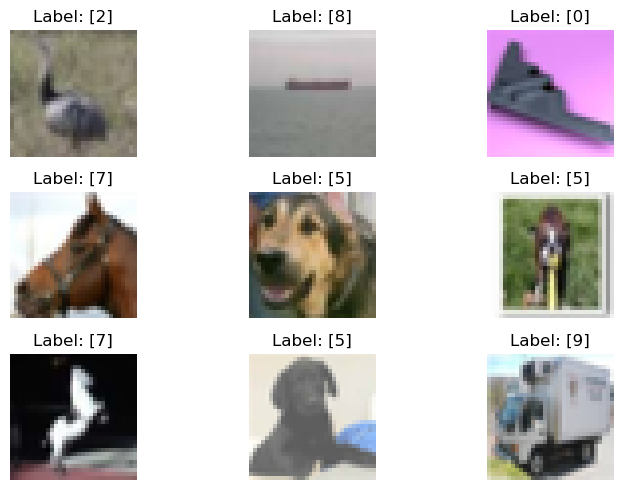

In [12]:
# Plot a few random images from the test set
def plot_random_images(x_test, y_test, num_images=9):
    plt.figure(figsize=(8, 5))
    for i in range(num_images):
        idx = np.random.randint(0, x_test.shape[0])
        plt.subplot(3, 3, i+1)
        plt.imshow(x_test[idx])
        plt.title(f"Label: {y_test[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to plot random images
plot_random_images(x_train, y_train)

Since the dataset is quite large, we will use a subset of it. Remember, our goal is to understand ResNet, not to achieve state-of-the-art results.

In [13]:
# Choose the number of samples for a smaller dataset
num_samples = 3000

# Randomly select a subset of the training data
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
x_train_small = x_train[indices]
y_train_small = y_train[indices]

# Use a subset of the test set as well
# Shuffle the test set before selecting a subset
indices = np.random.permutation(x_test.shape[0])  # Get a random permutation of the test set indices
x_test_small = x_test[indices[:500]]  # Select the first 500 randomly shuffled samples
y_test_small = y_test[indices[:500]]  # Select the corresponding labels


Pre-processing

In [15]:
# Normalize pixel values to [0, 1]
x_train_small = x_train_small / 255.0
x_test_small = x_test_small / 255.0

# Convert labels to one-hot encoding
y_train_small = to_categorical(y_train_small, 10)
y_test_small = to_categorical(y_test_small, 10)

# Resize images to 64x64 (or the input size expected by your model)
x_train_small = tf.image.resize(x_train_small, (64, 64))
x_test_small = tf.image.resize(x_test_small, (64, 64))

2024-12-09 15:17:39.202302: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 73728000 exceeds 10% of free system memory.
2024-12-09 15:17:39.257331: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 147456000 exceeds 10% of free system memory.


Let's create our data generator.

In [30]:

BATCH_SIZE = 64


# Convert the data to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_small, y_train_small))
val_dataset = tf.data.Dataset.from_tensor_slices((x_test_small, y_test_small))

# Data augmentation for training set
train_dataset = train_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
train_dataset = train_dataset.map(lambda x, y: (tf.image.random_flip_up_down(x), y))
train_dataset = train_dataset.map(lambda x, y: (tf.image.random_contrast(x, 0.2, 0.5), y))
train_dataset = train_dataset.map(lambda x, y: (tf.image.random_brightness(x, 0.1), y))

# Batch and shuffle the datasets
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [16]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train_small)

<a name="#6"> </a>
## <font color='blue'> <b> 6. Models </b> </font>

First, we will create a model without residual connections. Then, we will create our ResNet to compare the results later.

<a name="6.1"></a>
### <b> <font color='#2874a6'> 6.1. Simple Model </font> </b>

In [21]:
def SimpleCNN(num_classes, input_shape=(64, 64, 3)):
    """
    Simplified CNN model without residual connections.

    Arguments:
    input_shape -- shape of the images of the dataset
    num_classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = Conv2D(128, (3, 3), strides=(1, 1), name='conv2', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 3
    X = Conv2D(256, (3, 3), strides=(2, 2), name='conv3', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv3')(X)
    X = Activation('relu')(X)

    # Stage 4
    X = Conv2D(512, (3, 3), strides=(1, 1), padding='SAME', name='conv4', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv4')(X)
    X = Activation('relu')(X)

    # Stage 5
    X = Conv2D(1024, (3, 3), strides=(1, 1), padding='SAME', name='conv5', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv5')(X)
    X = Activation('relu')(X)

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax', name='fc' + str(num_classes), 
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='SimpleCNN')

    return model


In [22]:
model = SimpleCNN(NUM_CLASSES)

Train, fit and evaluation

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)



Epoch 1/20
47/47 [==============================] - 90s 2s/step - loss: 1.7324 - accuracy: 0.3520 - val_loss: 2.4850 - val_accuracy: 0.2300
Epoch 2/20
47/47 [==============================] - 83s 2s/step - loss: 1.6178 - accuracy: 0.4070 - val_loss: 1.7830 - val_accuracy: 0.4240
Epoch 3/20
47/47 [==============================] - 90s 2s/step - loss: 1.5387 - accuracy: 0.4323 - val_loss: 1.7870 - val_accuracy: 0.3780
Epoch 4/20
47/47 [==============================] - 92s 2s/step - loss: 1.5318 - accuracy: 0.4490 - val_loss: 2.4809 - val_accuracy: 0.3000
Epoch 5/20
47/47 [==============================] - 97s 2s/step - loss: 1.5123 - accuracy: 0.4383 - val_loss: 2.6699 - val_accuracy: 0.3140
Epoch 6/20
47/47 [==============================] - 86s 2s/step - loss: 1.4390 - accuracy: 0.4807 - val_loss: 2.5734 - val_accuracy: 0.2640
Epoch 7/20
47/47 [==============================] - 84s 2s/step - loss: 1.4121 - accuracy: 0.4867 - val_loss: 2.3997 - val_accuracy: 0.3340
Epoch 8/20
47/47 [==

In [33]:
test_loss, test_accuracy = model.evaluate(x_test_small, y_test_small)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 [==============================] - 0s 20ms/step - loss: 1.7830 - accuracy: 0.4240
Test Accuracy: 42.40%


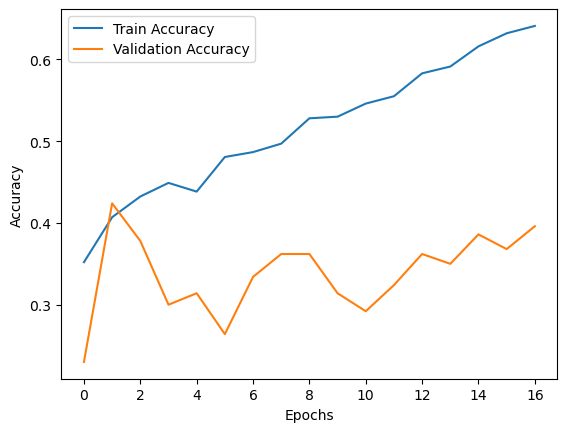

In [37]:
plot_accuracy(history)

<a name="6.2"></a>
### <b> <font color='#2874a6'> 6.2. Residual Network </font> </b>

In ResNets, a shortcut or skip connection enables the model to bypass specific layers:



<img src="images/skip_connection.png"/>



By stacking these ResNet blocks, we can create very deep networks. Importantly, the shortcut simplifies learning by allowing a block to learn an identity function, ensuring new blocks can be added with minimal risk of degrading training performance.

Interestingly, research suggests that the ability to learn identity functions contributes significantly to ResNets' success, potentially more than skip connections' role in mitigating vanishing gradients.

ResNets use two types of blocks, depending on input-output dimension alignment:
- Identity block
    - Used when input and output dimensions are the same.
- Convolutional block
    - Used when input and output dimensions differ.

<a name="6.2.1"></a>
### <b> <font color='#2980b9'> 6.2.1. Identity Block </font> </b>


The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$).

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step.


In this exercise, the skip connection "skips over" 3 layers.


<img src="images/id_block.png"/>




In [39]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X) # normalize the channel axis
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X) # normalize the channels axis
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X) # normalize the channels axis

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    
    return X

<a name="6.2.2"></a>
### <b> <font color='#2980b9'> 6.2.2. Convolutional Block </font> </b>

You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut 


<img src="images/conv_block.png"/>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 


In [40]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X) # normalize the channels axis
    X = Activation('relu')(X)
    

    # Second component of main path
    X = Conv2D(F2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X) # normalize the channels axis
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut) # normalize the channels axis

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 
    
    
    return X

<a name="6.2.3"></a>
### <b> <font color='#2980b9'> 6.2.3. ResNet Model (50 layers)</font> </b>


You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/Resnet.png"/>


In [99]:
def ResNet50(num_classes, input_shape=(64, 64, 3)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    num_classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[32, 32, 128], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=3, block='a', s=2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=4, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=5, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax', name='fc' + str(num_classes), 
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


In [104]:
resnet_model = ResNet50(num_classes=10, input_shape=(64, 64, 3))

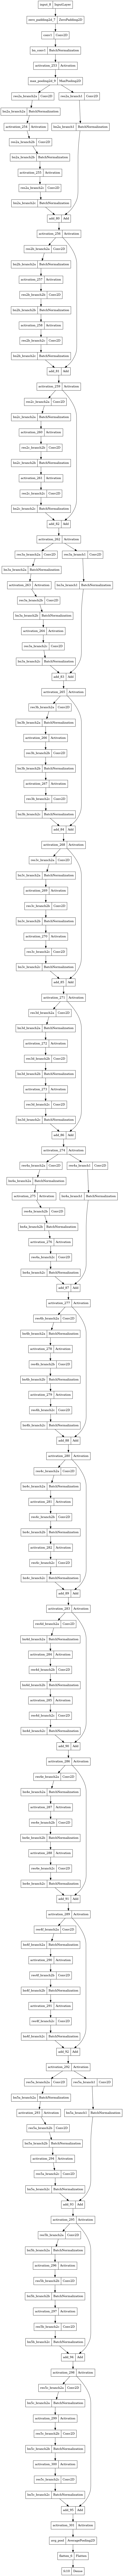

In [106]:
from tensorflow.keras.utils import plot_model

plot_model(resnet_model)

### Train, fit and evaluation

In [107]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = resnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)


In [91]:
test_loss, test_accuracy = model.evaluate(x_test_small, y_test_small)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


16/16 [==============================] - 1s 55ms/step - loss: 2.5457 - accuracy: 0.2720
Test Accuracy: 27.20%


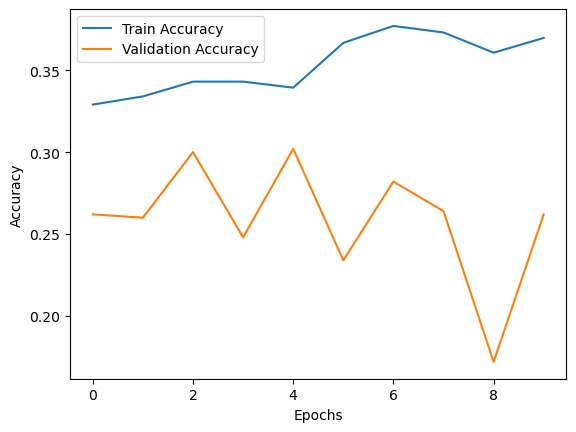

In [70]:
plot_accuracy(history)

### Analysis

Let's plot the confussion matrix and some misclassified labels.

In [71]:
# Predict on the test set
y_pred = model.predict(x_test_small)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_small, axis=1)

16/16 [==============================] - 1s 54ms/step


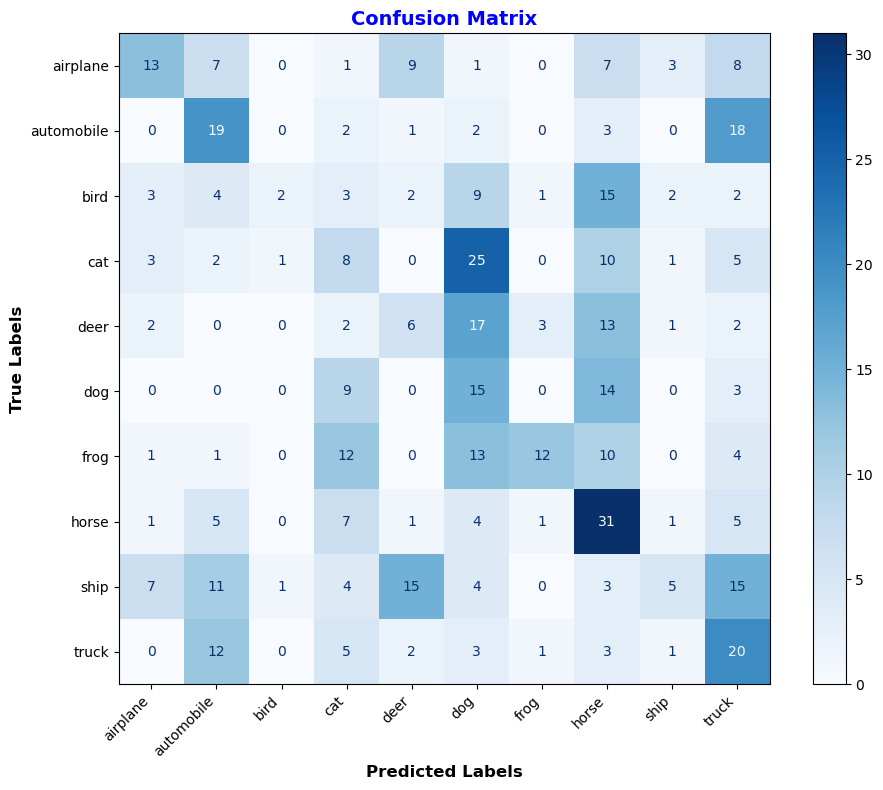

In [85]:
# confussion matrix
plot_confussion_matrix(y_true_classes, y_pred_classes)

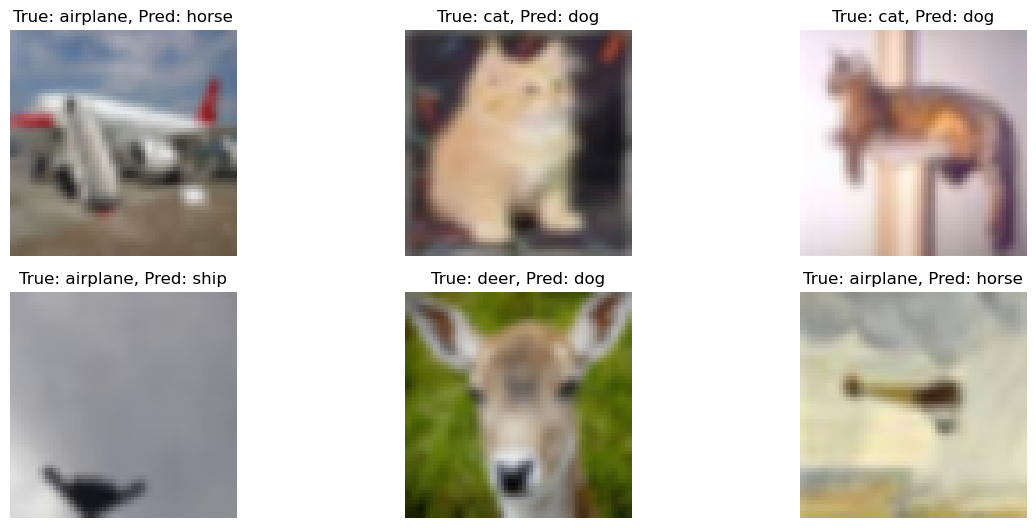

In [86]:
# Find misclassified images
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

# Call the function to plot misclassified images
plot_misclassified_images(misclassified_indices, x_test_small, y_test_small, y_pred_classes)
